# Łączenie różnych modeli w celu uczenia zespołowego


In [53]:
from IPython.display import Image

W rozdziale info o :
- uzyskanie progrnozy na podstawie większowściowego głosowania
- zmniejszanie przetrenowania modelu poprzez tworzenie losowych kombinacji zesstawu uczącego 
- budowanie potęznych modeli ze słabych klasyfikatorów, które uczą się na własnych błędach


- Celem metod zespołowych (ensemble methods) jest łączenie różnych klasyfikatorów w megaklasyfikator z większą skutecznością
- wykorzystanie zasady większościowego głosowania (majority voting)->wybór etykiety klas przewidzianiej przez większość klasyf (dla binarnych klas)
- w wieloklasowym -> względna więkoszość głosów (plurality voting)

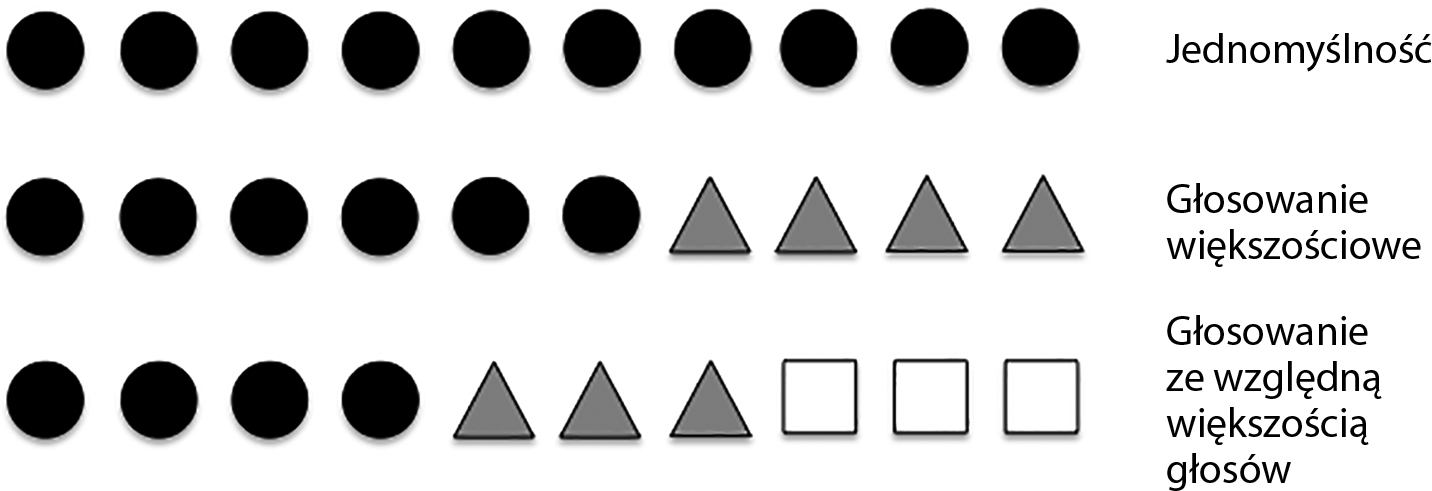

In [54]:
Image(filename='./rysunki/rozdzial 7/07_01.png', width=500)

- różne klasyfikatory uczone (C1,...,Cm)
- lub ten sam algorytm uczenia z różnymi podzbiorami uczącymi
- $ \hat{y} =moda \{ C_1(x),...,C_m(x)\}$

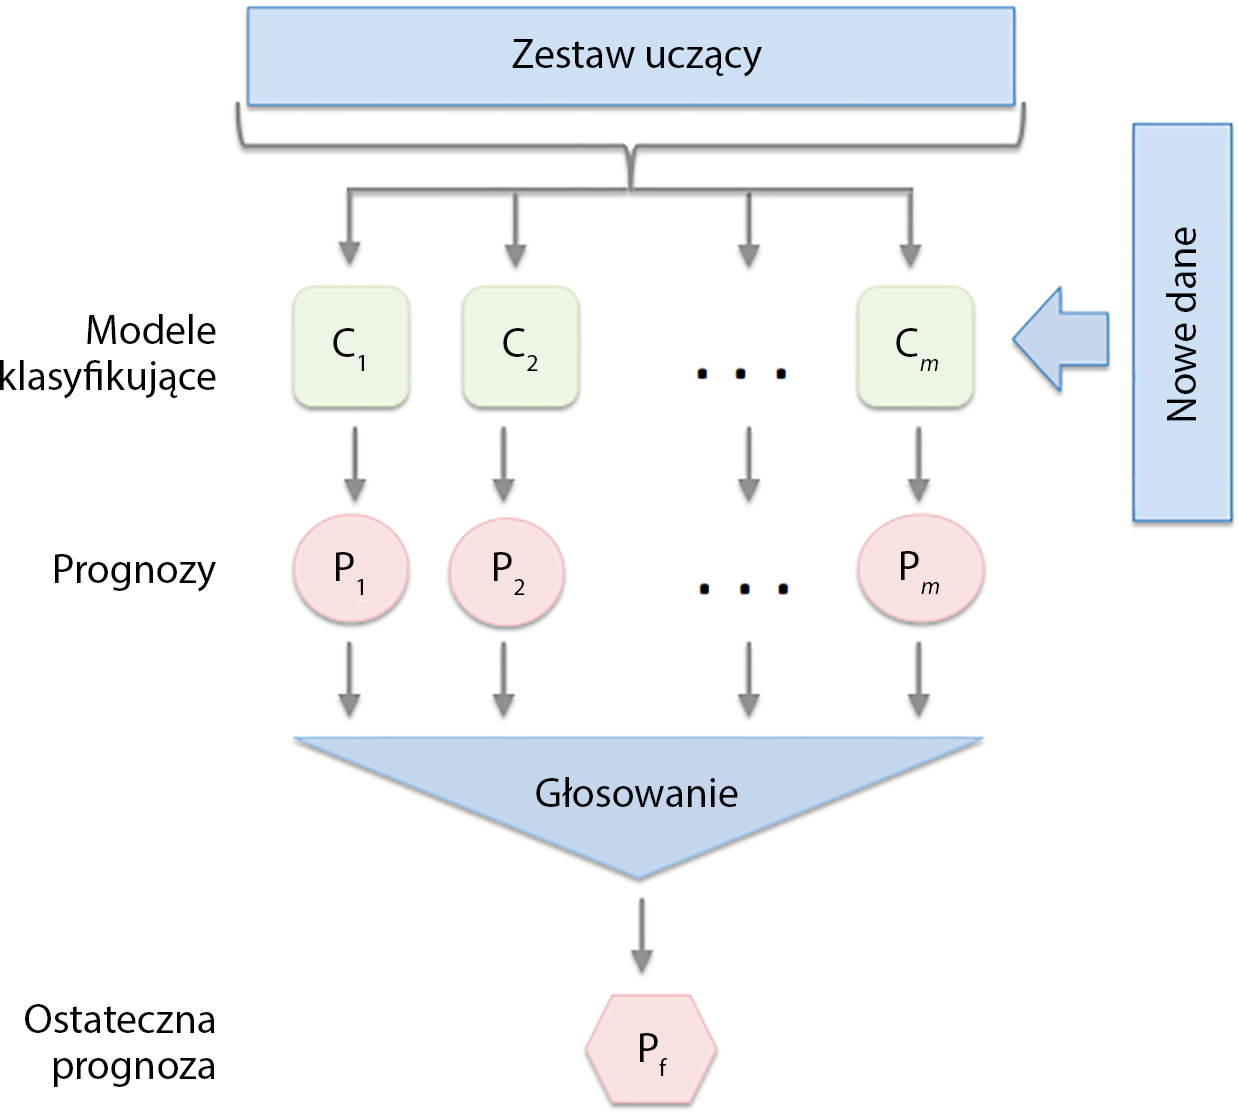

In [55]:
Image(filename='./rysunki/rozdzial 7/07_02.png', width=600)

- na podstawie prostych reguł kombinatoryki:
- n algorytmów ma taki sam błąd $\epsilon$
- niezależne, stopy błędu nieskolerowane
- prawdopobieństwo popełnienianie błędu przez zespół klasyf. jako funkcja masy prawdopo. dla rozkładu dwumianowego:
$$ P (y\geq k)= \sum_k^n{\binom{N}{k} \epsilon ^ k(1-\epsilon)^{n-k}=\epsilon_{zespół}}$$
- $\binom{N}{k}$ to współczynnik dwumianowy n po k.
- innymi słowy obliczamy prawdopodobieństwo wystąpienia błędnej prognozy przez zespół
- przykład dla n=11 i stopie błędu=0.25 i połowie klasyfikatorów uznanych z błędnym wynikiem
$$ P (y\geq k)= \sum_{k=6}^n{\binom{11}{k} 0.25^k(1-0.25)^{11-k}}=0,034$$

In [56]:
# porównanie klasyfikatora zespołowego z bazowym dla różnych wartości stopy błędu
from scipy.special import comb
import math


def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.0))
    probs = [comb(n_classifier, k) * error**k *
             (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [57]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

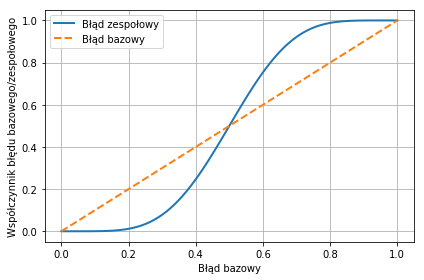

In [58]:
import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11,
                             error=error)
              for error in error_range]
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(error_range,
         ens_errors,
         label='Błąd zespołowy',
         linewidth=2)

plt.plot(error_range,
         error_range,
         linestyle='--',
         label='Błąd bazowy',
         linewidth=2)

plt.xlabel('Błąd bazowy')
plt.ylabel('Współczynnik błędu bazowego/zespołowego')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
#plt.savefig('./rysunki/07_03.png', dpi=300)
plt.show()

Czyli błąd zespołowy zawsze mniejszy niż dla pojedynczego klasyfikatora pod warunkiem, że poszczególne algorytmy skuteczniejsze od losowego zgadywania

##  Implementacja prostego klasyfikatora wykorzystującego głosowanie większościowe

Ważone głosowane większościowe:
$$ \hat{y}=arg max_i \sum_{j=1}^m w_j \chi_A(C_j(x)=i)$$
- $w_j$ to waga powiązana z klasfyikatorem bazowym Cj, $\hat{y}$ to prognozawana przez zespół etykieta klas, $\chi_A$ stanowi funkcję charakterystyczną, A symblizuje zbior unikatowych etykiet klas.
- przy równych wagach: $\hat{y}= moda\{C_1(x),...,C_m(x)\}$
- przykład $C_1(x)\rightarrow \ 0,\ C_2(x)\rightarrow \ 0,\ C_3(x) \rightarrow \ 1$ co daje $\hat{y}= moda\{0,0,1\}=0$
- przy wagach  0,6 dla C3 i 0,2 dla C1 i C2:
- $arg \ max_i[0,2\times i_0+0,2\times i_0+0,6\times i_1]=1$


In [59]:
# jak w pythonie
import numpy as np
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

Przy korzystaniu z prawdopodobieństwa przewidywań:
$\hat{y}=arg \max_\limits{i} \sum_{j=1}^m{w_jp_{ij}}$
- gdzie $w_{ij}$ to prawdopodobieństwo j-tego klasyfikatora dla i-tej klasy
- przykład do 3 klasyfikatorów z prawd. $C_1(x)\rightarrow \ [0,9,0,1],C_2(x)\rightarrow \ [0,8,0,2],C_2(x)\rightarrow \ [0,4,0,6]$
$$ p(i_0|x)=0,2 \times 0,9 + 0,2 \times 0,8 + 0,6 \times 0,4= 0,58$$
$$ p(i_1|x)=0,2 \times 0,1 + 0,2 \times 0,2 + 0,6 \times 0,6= 0,42$$
 $$\hat{y}=arg \max_\limits{i} [p(i_0|x),p(i_1|x)]=0$$

In [60]:
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
np.argmax(p)

[0.58 0.42]


0

In [61]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ Klasyfikator zespołowy (głosowanie większościowe)

    Parametry
    ----------
    classifiers : tablicopodobny, wymiary = [n_klasyfikatorów]
      Różne klasyfikatory tworzące zespół

    vote : łańcuch znaków, {'classlabel', 'probability'} (domyślnie: 'classlabel')
      Jeżeli jest wybrany argument 'classlabel', to prognoza jest przeprowadzana przy użyciu funkcji
        argmax wobec etykiet klas. W przeciwnym wypadku ('probability'), wynik funkcji argmax wobec sumy
        prawdopodobieństw zostaje użyty do prognozowania etykiety klas (zalecane dla skalibrowanych klasyfikatorów).

    weights : tablicopodobne, wymiary = [n_klasyfikatorów], Opcjonalny, (domyślnie: None)
      Po wprowadzeniu listy wartości typu `int` lub `float`, Klasyfikatory są ważone pod kątem ważności. Jeśli
      `weights=None`, wykorzystywane są takie same wagi.

    """

    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Dopasowywanie klasyfikatorów.

        Parametry
        ----------
        X : {tablicopodobny, macierz rzadka}, wymiary = [n_próbek, n_cech]
            Macierz próbek uczących.

        y : tablicopodobny, wymiary = [n_próbek]
            Wektor docelowych etykiet klas.

        Zwraca
        -------
        self : obiekt

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("parametr vote przyjmuje wyłącznie wartości 'probability' lub 'classlabel'"
                             "; wybrano (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Liczba klasyfikatorów musi być równa liczbie wag'
                             '; dostępne wagi: %d, klasyfikatory: %d'
                             % (len(self.weights), len(self.classifiers)))

        # dzięki klasie LabelEncoder etykiety klas rozpoczynają się
        # od wartości 0, co jest bardzo ważne podczas wywołania np.argmax
        # w self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        # dopasowanie enkodera
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Prognozowanie etykiet klas dla próbki X.

        Parametry
        ----------
        X : {tablicopodobny, macierz rzadka}, wymiary = [n_próbek, n_cech]
            Macierz próbek uczących.

        Zwraca
        ----------
        maj_vote : tablicopodobny, wymiary = [n_próbek]
            Przewidywane etykiety klas.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # wartość 'classlabel'

            #  zbiera wyniki z wywołań metody clf.predict
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T
            # tworzy tablicę
            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x,
                                      weights=self.weights)),
                axis=1,
                arr=predictions)
            # wykonuje funkcje 1D na tablicy
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Prognozowania prawdopodobieństwa przynależności próbki X do danej klasy.

        Parametry
        ----------
        X : {tablicopodobny, macierz rzadka}, wymiary = [n_próbek, n_cech]
            Wektory uczenia, gdzie n_próbek oznacza
            liczbę próbek, a n_cech – liczbę cech.

        Zwraca
        ----------
        avg_proba : tablicopodobny, wymiary = [n_próbek, n_klas]
            Ważone, uśrednione prawdopodobieństwo wystąpienia każdej klasy na daną próbkę.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Pobiera nazwy parametrów klasyfikatora dla klasy GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

##  Łączenie różnych algorytmów w celu klasyfikacji za pomocą głosowania większościowego

In [62]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1)

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
import numpy as np
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])

pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Regresja logistyczna',
              'Drzewo decyzyjne', 'K-najbliżsi sąsiedzi']

print('Dziesięciokrotny sprawdzian krzyżowy:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("Obszar pod krzywą ROC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

Dziesięciokrotny sprawdzian krzyżowy:

Obszar pod krzywą ROC: 0.92 (+/- 0.20) [Regresja logistyczna]
Obszar pod krzywą ROC: 0.92 (+/- 0.15) [Drzewo decyzyjne]
Obszar pod krzywą ROC: 0.93 (+/- 0.10) [K-najbliżsi sąsiedzi]


In [64]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Głosowanie Większościowe']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train,
                             y=y_train, cv=10, scoring='roc_auc')
    print("Obszar pod krzywą ROC: %0.2f (+/- %0.2f) [%s]" %(scores.mean(),scores.std(), label))

Obszar pod krzywą ROC: 0.92 (+/- 0.20) [Regresja logistyczna]
Obszar pod krzywą ROC: 0.92 (+/- 0.15) [Drzewo decyzyjne]
Obszar pod krzywą ROC: 0.93 (+/- 0.10) [K-najbliżsi sąsiedzi]
Obszar pod krzywą ROC: 0.97 (+/- 0.10) [Głosowanie Większościowe]


Jak widać skuteczność klasyfikatora zespołowego wyższa niż klasyfikatorów bazowych

## Ewaluacja i Strojenie klasyfikatora zespołowego 

Obliczmy krzywe ROC przy użyciu danych testowych

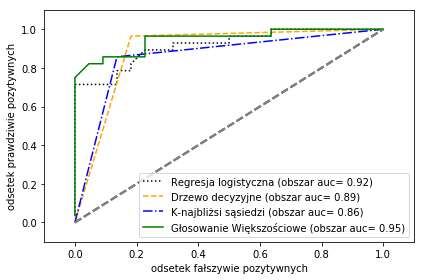

In [65]:
from sklearn.metrics import roc_curve, auc
colors = ['black', 'orange', 'blue', 'green']
linestyle = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyle):
    #przy założeniu że etykieta klasy pozytywnej to 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(
        fpr,
        tpr,
        color=clr,
        linestyle=ls,
        label='%s (obszar auc= %0.2f)' % (label, roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], linestyle='--',color='gray',linewidth=2)
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.grid()
    plt.xlabel('odsetek fałszywie pozytywnych')
    plt.ylabel('odsetek prawdziwie pozytywnych')
    plt.tight_layout()
   
    

<div class="mark">
Wnioski: Oczywiście najlepszy klasyfikator zespołowy, k-najbliższych sąsiadów za bardzo dopasowany (uczące =0.93, testowe=0.86)</div><i class="fa fa-lightbulb-o "></i>

Sprawdzimy regiony decyzyjne, musimy przeskalować drzewo decyzyjne


C:\Users\zija\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


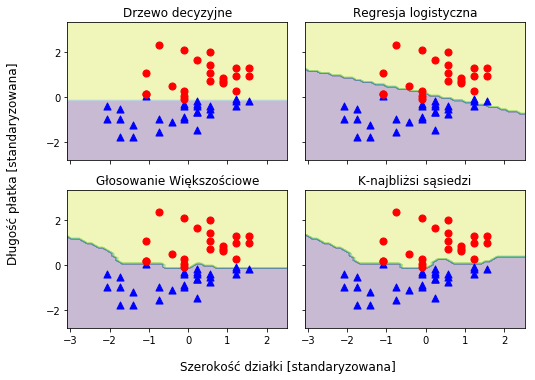

In [66]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import  product
x_min= X_train_std[:,0].min()-1
x_max= X_train_std[:,0].max()+1
y_min= X_train_std[:,1].min()-1
y_max= X_train_std[:,1].max()+1
xx, yy =np.meshgrid(np.arange(x_min,x_max,0.1),np.arange(y_min,y_max,0.1))
f,axarr= plt.subplots(nrows=2,ncols=2,sharex='col',sharey='row',figsize=(7,5))
for idx, clf, tt in zip(product([0,1],[1,0]),all_clf,clf_labels):
    clf.fit(X_train_std,y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z= Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, 
         s='Szerokość działki [standaryzowana]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Długość płatka [standaryzowana]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.tight_layout()
#plt.savefig('./rysunki/07_05', bbox_inches='tight', dpi=300)
plt.show()    
    

- regiony decyzyjne okazują się hybrydą regionów składowych modeli, podobny k-najbliższych sąsiadów, powyżej 1 dla szerokości działki wygląda jak w modelu drzewa

-wywoływanie metody get_params 

In [67]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=No

Na podstawie danych konfigurujemy odwrotny parametr C alg. regresji logistycznej, a także wyskość drzewa decyzyjnego

In [68]:
from sklearn.model_selection import GridSearchCV
params={'decisiontreeclassifier__max_depth':[1,2],
       'pipeline-1__clf__C': [0.001, 0.1,100.0]}
grid= GridSearchCV(estimator=mv_clf,
                  param_grid=params,
                  cv=10,
                  scoring='roc_auc')
grid.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [69]:
cv_keys = ('mean_test_score', 'std_test_score', 'params')
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
        print("%0.3f +/- %0.2f %r"
              % (grid.cv_results_[cv_keys[0]][r], 
                 grid.cv_results_[cv_keys[1]][r] / 2.0, 
                 grid.cv_results_[cv_keys[2]][r]))
    

0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


Wnioski:
- najlepsze rezultaty przy niskej regularyzacji (c=100)
- wysokość drzewa zdaje się nie mieć wpływu na wyniki, sugeruje, że odpowiednio dobrano granice decyzyjne

__Doczytać uwagi z książki__ str. 221

In [70]:
grid.best_estimator_.classifiers

[Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=1, p=2,
            weights=

In [71]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None)

In [72]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None)

##  Agregacja - tworzenie zespołu klasyfikatorów za pomocą próbek początkowych

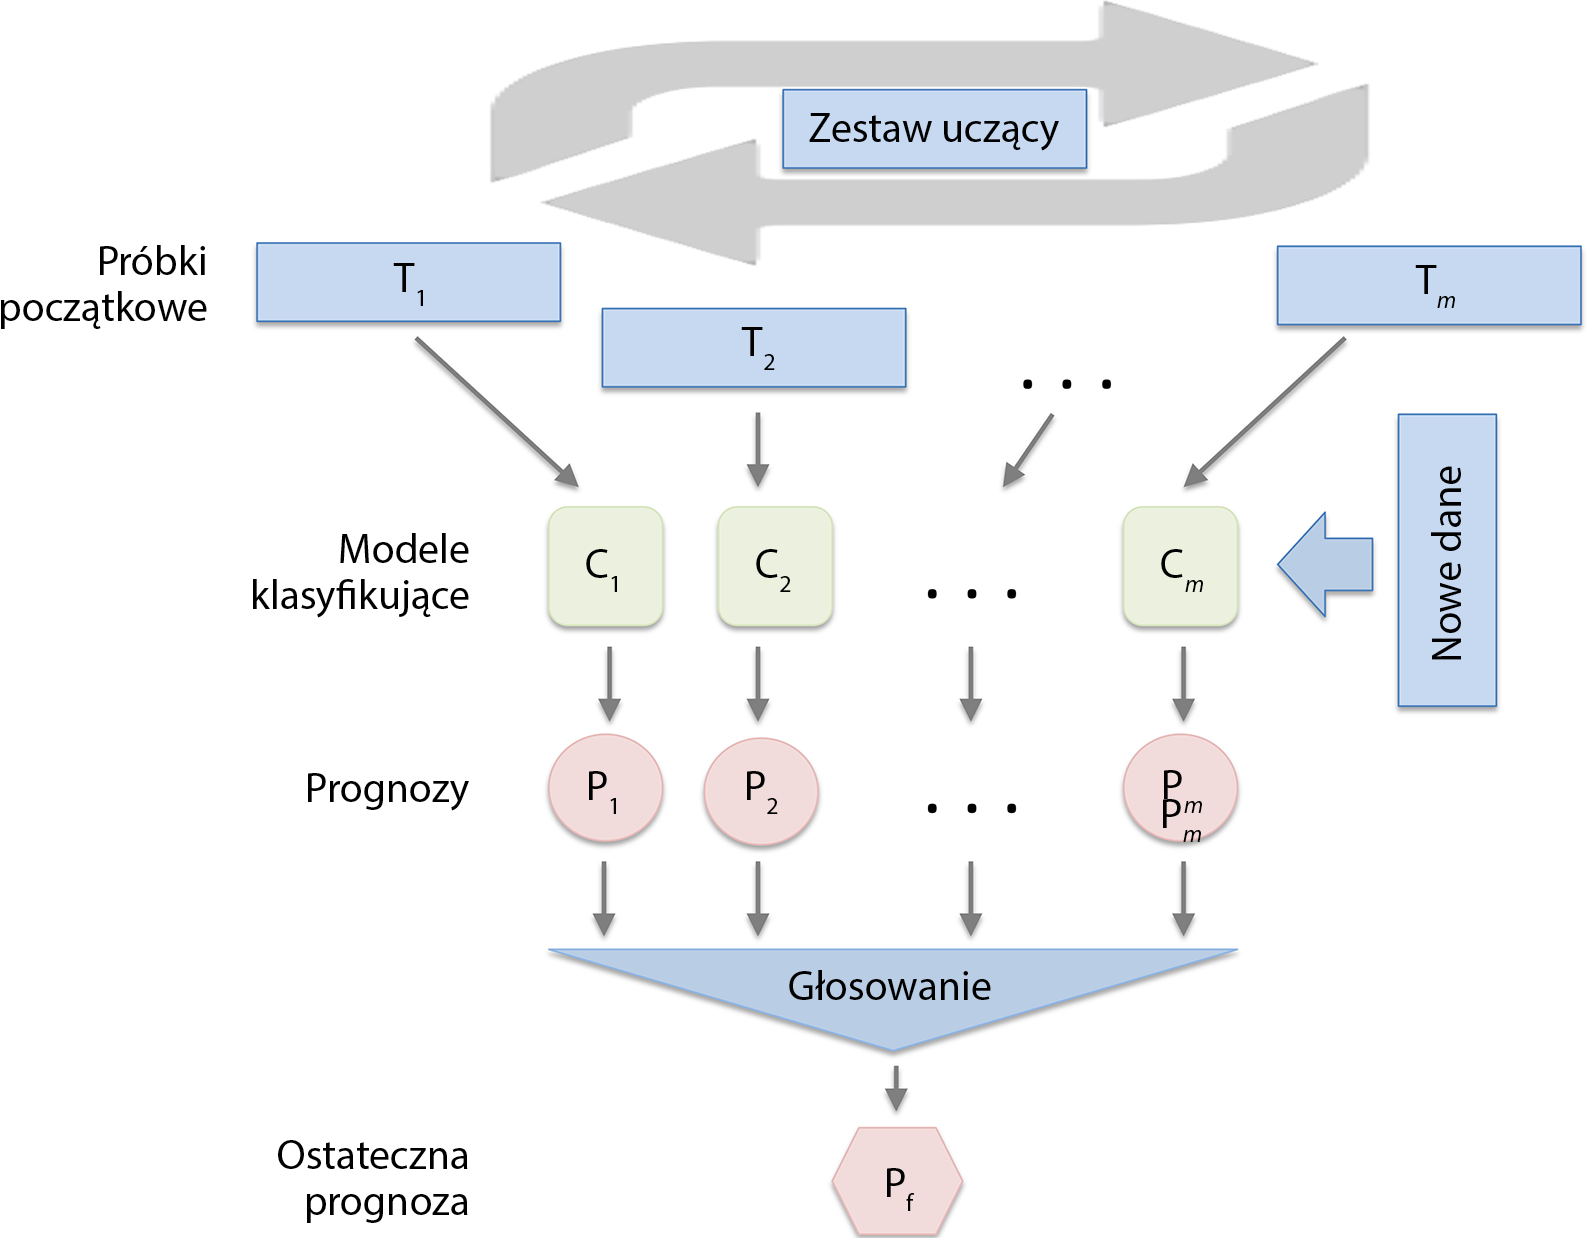

In [73]:
Image(filename='./rysunki/rozdzial 7/07_06.png', width=600)

- agregacja (bagging) stanowi tech. uczenia zespołowego
- nie wykorzystujemy tego samego zbioru danych testowych do uczenia poszczególnych składowych 
- tworzymy nowe próbki początkowe (bootstrap samples- podzbiór losowych próbek ze zwracaniem)) z pierwotnego zestawu uczącego
- działanie na rysunku poniżej


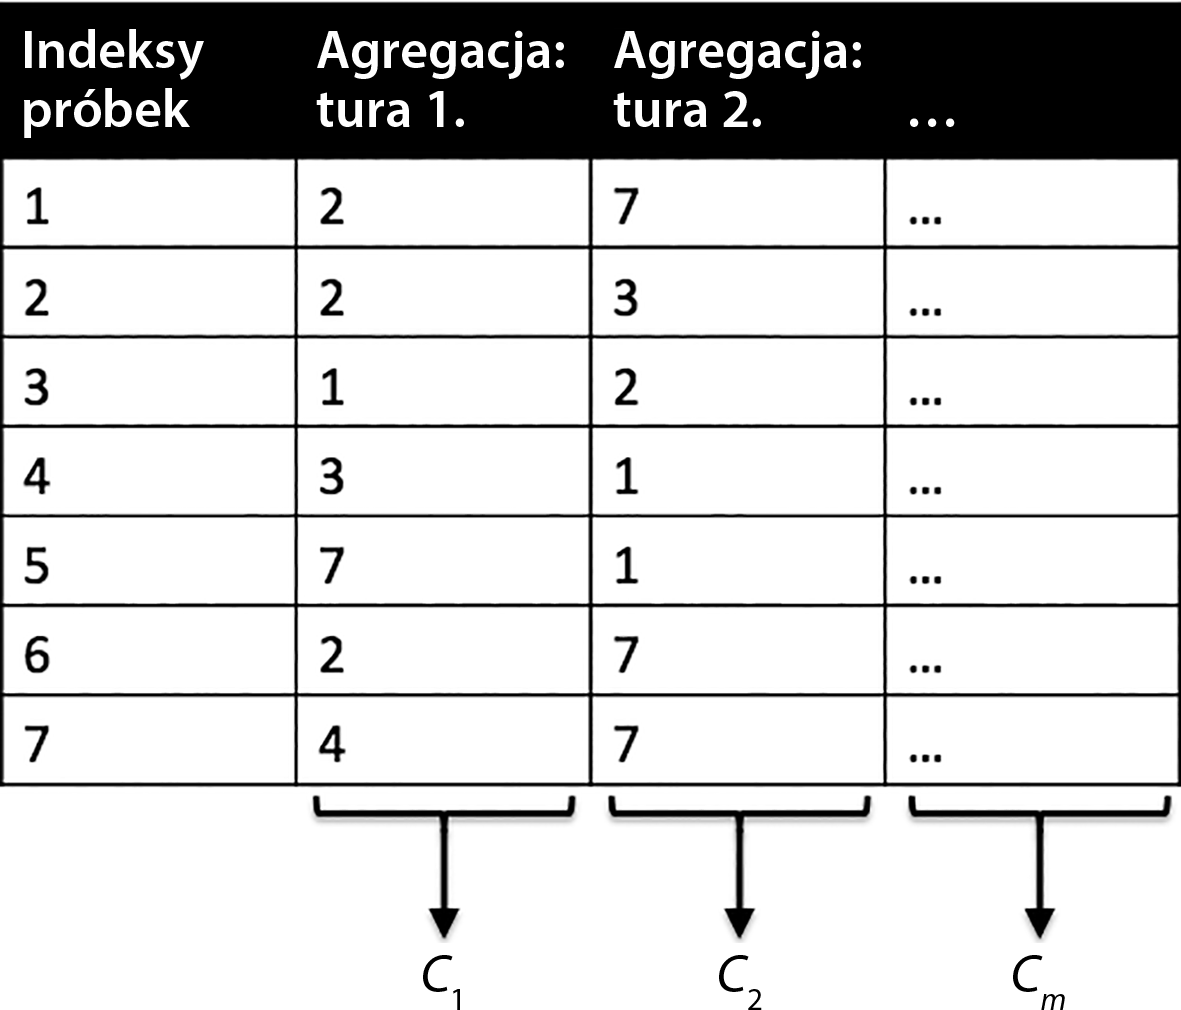

In [74]:
Image(filename='./rysunki/rozdzial 7/07_07.png', width=400)

- 7 różnych wystąpień uczących, które w każdej turz uczącej są losowo dobierane ze zwracaniem 
- próbki początkowe są używane do trenowani klasyf. Cj - najczęściej nieprzycinane drzewo decyzyjne
- powiązanie z klasyfikatorem losowego lasu
- więcej informacji w artykule, link w książce str. 222

<br>
Poniżej problem klasyfikacji zestawu Wine

In [75]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Etykieta klas', 'Alkohol', 'Kwas jabłkowy', 'Popiół', 
'Zasadowość popiołu', 'Magnez', 'Całk. zaw. fenoli', 
'Flawonoidy', 'Fenole nieflawonoidowe', 'Proantocyjaniny', 
'Intensywność koloru', 'Odcień', 'Transmitancja 280/315 nm', 'Prolina']

# porzuca klasę 1
df_wine = df_wine[df_wine['Etykieta klas'] != 1]

y = df_wine['Etykieta klas'].values
X = df_wine[['Alkohol', 'Odcień']].values
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.40, 
                             random_state=1)


In [76]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(
    criterion='entropy', max_depth=None, random_state=1)
bag = BaggingClassifier(
    base_estimator=tree,
    n_estimators=500,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=1,
    random_state=1)


In [77]:
from sklearn.metrics import  accuracy_score
tree= tree.fit(X_train, y_train)
y_train_pred= tree.predict(X_train)
y_test_pred= tree.predict(X_test)
tree_train= accuracy_score(y_train, y_train_pred)
tree_test= accuracy_score(y_test, y_test_pred)
print('Dokładność drzewa decyzyjnego dla danych uczących/testowych %.3f/%.3f'
      % (tree_train, tree_test))
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Dokładność agregacji dla danych uczących/testowych %.3f/%.3f'
      % (bag_train, bag_test))

Dokładność drzewa decyzyjnego dla danych uczących/testowych 1.000/0.833
Dokładność agregacji dla danych uczących/testowych 1.000/0.896


- Drzewo decyzyjne wykazuje 100% skuteczność dla danych uczących, ale słabą dla testowych, zbyt dużą wariancję, przetrenowanie
- Klasyfikator agregacji wykazuje nieznacznie większą skuteczność uogólnania wobec danych testowych
- porównanie regionów decyzyjnych:


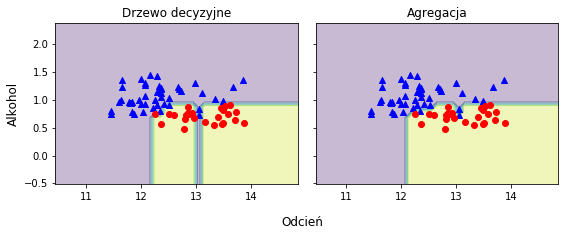

In [78]:
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Drzewo decyzyjne', 'Agregacja']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], 
                       X_train[y_train==0, 1], 
                       c='blue', marker='^')
    
    axarr[idx].scatter(X_train[y_train==1, 0], 
                       X_train[y_train==1, 1], 
                       c='red', marker='o')
    
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alkohol', fontsize=12)
plt.text(10.2, -1.2, 
         s='Odcień', 
         ha='center', va='center', fontsize=12)
    
plt.tight_layout()
#plt.savefig('./rysunki/07_08.png', 
#            dpi=300, 
#            bbox_inches='tight')
plt.show()

- to był bardzo prosty przykład agregacji
- w praktyce złożone zadania klasyfikacji oraz wielowymiarowość zestawów danych mogą z łatwością doprowadzić do przetrenowania pojedynczego drzewa, 
- wtedy technika agregacji okazuje się przydatna
- może on zredukować wariancję modelu
- nie nadaje się do zmniejszania obciążenia, dlatego dobiera się zespoły klasyfikatorów o małym obciążeniu, np. nieprzycinane drzewa decyzyjne 

## Usprawnienie słabych klasyfikatorów za pomocą wzmocnienia adaptacyjnego

Omówienie 